# Remaning Useful Life Estimation using TSFEL

In this example, we will perform a Remaining Useful Life (RUL) estimation using TSFEL. We will use a public dataset entitled NASA C-MAPSS, which contains multivariate time series. TSFEL will be used to extract the features which will be learned by a classifier. In this case, we used the XGBoost. Nevertheless, it might be changed to another suitable classifier.

The xgboost can be installed using the following command:

```bash
pip install xgboost
```

In [ ]:
%matplotlib inline

import zipfile

import numpy as np
import pandas as pd
import wget
import xgboost
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)

import tsfel

### Auxiliary Methods

In [2]:
def fill_missing_values(df):
    """
    Handle eventual missing data. Strategy: replace with mean.
    """

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    return df

## Dataset

We will be using the [NASA C-MAPSS dataset](https://core.ac.uk/download/pdf/10539072.pdf). It contains multivariate data from sensor values measuring the simulated behavior of large commercial turbofan engines. Several experiments were performed under different operating conditions. Each experiment follows a certain number of cycles until engine failure.

The objective is to predict the Remaining Useful Life (RUL), measured in cycles, of an engine. In this notebook, we'll estimate the RUL using regression from a set of features extracted from TSFEL.

### Read train, test and RUL data from file

The NASA C-MAPSS contains four sub-datasets. In this example, we used the FD001.

In [3]:
url_path = (
    "https://raw.githubusercontent.com/LahiruJayasinghe/RUL-Net/master/CMAPSSData/"
)

data_train = pd.read_csv(url_path + "train_FD001.txt", sep=" ", header=None)
data_test = pd.read_csv(url_path + "test_FD001.txt", sep=" ", header=None)
lines_rul = pd.read_csv(url_path + "RUL_FD001.txt", sep=" ", header=None)

# Drop the last two columns since they do not contain any data
data_train.dropna(axis="columns", how="all", inplace=True)
data_test.dropna(axis="columns", how="all", inplace=True)
lines_rul.dropna(axis="columns", how="all", inplace=True)

# Attach the header names
cols = ["id", "cycles", "setting1", "setting2", "setting3"] + [
    "sensor" + str(i - 4) for i in range(5, data_train.shape[-1])
]
data_train.columns = cols
data_test.columns = cols

### Sensor Visualization

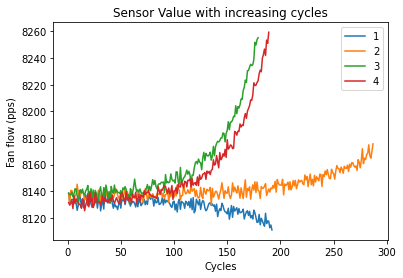

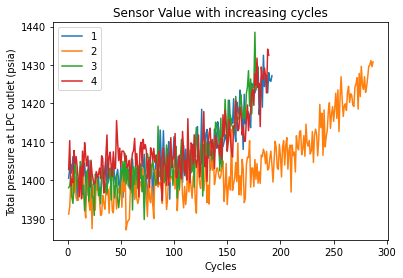

In [4]:
ids = [1, 2, 3, 4]

plt.figure()
plt.subplot(1, 1, 1)
[
    plt.plot(
        data_train[data_train["id"] == i]["cycles"],
        data_train[data_train["id"] == i]["sensor14"],
    )
    for i in ids
]
plt.xlabel("Cycles")
plt.ylabel("Fan flow (pps)")
plt.title("Sensor Value with increasing cycles")
legend = plt.legend(ids)
plt.setp(legend.get_texts(), color="black")
plt.show()

plt.subplot(1, 1, 1)
[
    plt.plot(
        data_train[data_train["id"] == i]["cycles"],
        data_train[data_train["id"] == i]["sensor4"],
    )
    for i in ids
]
plt.xlabel("Cycles")
plt.ylabel("Total pressure at LPC outlet (psia)")
plt.title("Sensor Value with increasing cycles")
legend = plt.legend(ids)
plt.setp(legend.get_texts(), color="black")
plt.show()

### Separate Dataframe by experiment

In [5]:
x_train_sig_no_overlap = [
    data_train[data_train["id"] == i + 1].drop(["id"], axis=1)
    for i in range(int(max(set(list(data_train["id"])))))
]
x_test_sig_no_overlap = [
    data_test[data_test["id"] == i + 1].drop(["id"], axis=1)
    for i in range(int(max(set(list(data_test["id"])))))
]

# Number of cycles for each training and test experiment
nr_cycles_train = [df.shape[0] for df in x_train_sig_no_overlap]
nr_cycles_test = [df.shape[0] for df in x_test_sig_no_overlap]

### Create training and test instances using time windows

We will now divide the dataset into windows from which the features will be calculated in the next step. 
We can most of the time divide the signal into windows and extract features using the main method [`time_series_features_extractor`](https://tsfel.readthedocs.io/en/latest/descriptions/modules/tsfel.feature_extraction.html#tsfel.feature_extraction.calc_features.time_series_features_extractor).
However, the way the dataset is organized makes it more practical to divide it into windows before the [`time_series_features_extractor`](https://tsfel.readthedocs.io/en/latest/descriptions/modules/tsfel.feature_extraction.html#tsfel.feature_extraction.calc_features.time_series_features_extractor) method. We will demonstrate in the next lines how this can be accomplished using the [`signal_window_splitter`](https://tsfel.readthedocs.io/en/latest/descriptions/modules/tsfel.utils.html#tsfel.utils.signal_processing.signal_window_splitter).

We define a `window size` of 30 cycles and an `overlap` of 90% between consecutive windows. These values are determined empirically. You can try different combinations and evaluate the impact on performance.

#### Train

In [6]:
window_size = 30
overlap = 0.9


X_train_sig = []
y_train = []

for i in range(len(x_train_sig_no_overlap)):
    x_train_window = tsfel.signal_window_splitter(
        x_train_sig_no_overlap[i], window_size=window_size, overlap=overlap
    )

    for data in x_train_window:
        X_train_sig.append(data)
        y_train.append(nr_cycles_train[i] - data.iloc[-1, 0])

X_train_sig = [i.drop(columns=["cycles"], axis=1) for i in X_train_sig]

#### Test

In [7]:
X_test_sig = []
y_test = []

for i in range(len(x_test_sig_no_overlap)):
    x_test_window = tsfel.signal_window_splitter(
        x_test_sig_no_overlap[i], window_size=window_size, overlap=overlap
    )

    for data in x_test_window:
        X_test_sig.append(data)
        y_test.append(nr_cycles_test[i] - data.iloc[-1, 0] + lines_rul.values[i][0])

X_test_sig = [i.drop(columns=["cycles"], axis=1) for i in X_test_sig]

Y labels are corrected to account for the fact that RUL is hard to determine for values above 125. <br>
A piecewise approximation is used in this case, with the target variable capped at 125. (Al-Dulaimi et al. [2019])<br>

That is: <br>
$ Y_{train/test} = Y_{actual}  $ if  $   Y_{actual} < 125$ <br>
$Y_{train/test} = 125, otherwise$

In [8]:
y_train = [min(i, 125) for i in y_train]
y_test = [min(i, 125) for i in y_test]

## Feature extraction

We will now use the main method for feature extraction. We will pass as input the dataset (previously divided into windows) and the configuration file. To simplify this demo, we will load all the available features.

In [9]:
cfg = tsfel.get_features_by_domain()

X_train = tsfel.time_series_features_extractor(cfg, X_train_sig, fs=1)
X_test = tsfel.time_series_features_extractor(cfg, X_test_sig, fs=1)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


## Data Pre-processing

In [10]:
X_train = fill_missing_values(X_train)
X_test = fill_missing_values(X_test)

nan_cols_train = [i for i in X_train.columns if X_train[i].isnull().any()]
X_train = X_train.drop(nan_cols_train, axis=1)
X_test = X_test.drop(nan_cols_train, axis=1)

X_train = X_train[X_test.columns]

We will now clean all the highly correlated features with one another using the [`correlated_features`](https://tsfel.readthedocs.io/en/latest/descriptions/modules/tsfel.utils.html#tsfel.utils.signal_processing.correlated_features) method and features with low variance.

In [11]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Normalising Features
min_max_scaler = preprocessing.StandardScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

### PCA decomposition to remove amount of features

Since, in this case, we calculated all the available features, it might be a good practice to reduce it to prevent model overfitting. A Principal Component Analysis (PCA) decomposition is performed below to retain a smaller percentage of variance and avoid overfitting.

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(f"Total explained variance: {sum(pca.explained_variance_ratio_)}")

Total explained variance: 0.9998135156674629


## Model training

In this example, the regression is performed using the [XGBoost](https://github.com/dmlc/xgboost).

### Hyperparameter tuning
The model's hyperparameters are tuned using a Randomized Search, alongside a stratified *k*-fold division, to ensure appropriate train/test division.

Since it takes some time to run (around 30 minutes for the current configuration), you might skip this part and use the parameters which we already find optimal.

In [ ]:
params = {
    # "num_boost_round" : [10,25,50],
    "subsample": [0.4, 0.6, 0.8, 1.0],
    "colsaple_bytree": [0.2, 0.4, 0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4, 5, 6, 7, 8],
    "eta": [0.02, 0.05, 0.1, 0.2, 0.3],
    "scale_pos_weight": [1, 2, 5, 10, 50],
    "n_estimators": [100, 200, 300],
}

xgb = xgboost.XGBRegressor(silent=False, objective="reg:squarederror")

folds = 5
param_comb = 60
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=params,
    n_iter=param_comb,
    n_jobs=10,
    cv=skf.split(X_train, y_train),
    verbose=1,
    random_state=1001,
)
random_search.fit(X_train, y_train)

random_search.best_params_

The following code trains the model, using a validation set obtained from the training dataset (90%-10%). The hyperparameters were chosen based on the hyperparameter tuning performed beforehand.

In [13]:
params = {
    "subsample": 0.6,
    "scale_pos_weight": 10,
    "n_estimators": 200,
    "max_depth": 6,
    "eta": 0.05,
    "njobs": 10,
    "objective": "reg:squarederror",
    "verbose": 1,
}

xgb = xgboost.XGBModel(**params)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.1, random_state=123
)

bst = xgb.fit(
    X_train,
    y_train,
    eval_metric="rmse",
    early_stopping_rounds=10,
    eval_set=[(X_validation, y_validation)],
    verbose=True,
)

[19:12:40] WARNING: ../src/learner.cc:573: 
Parameters: { "njobs", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:86.22340
[1]	validation_0-rmse:82.13308
[2]	validation_0-rmse:78.25592
[3]	validation_0-rmse:74.60017
[4]	validation_0-rmse:71.10377
[5]	validation_0-rmse:67.72871
[6]	validation_0-rmse:64.57423
[7]	validation_0-rmse:61.58714
[8]	validation_0-rmse:58.73659
[9]	validation_0-rmse:56.02198
[10]	validation_0-rmse:53.49625
[11]	validation_0-rmse:51.09299
[12]	validation_0-rmse:48.81043
[13]	validation_0-rmse:46.64473
[14]	validation_0-rmse:44.60117
[15]	validation_0-rmse:42.68088
[16]	validation_0-rmse:40.84541
[17]	validation_0-rmse:39.11684
[18]	validation_0-rmse:37.46106
[19]	validation_0-rmse:35.91323
[20]	validation_0-rmse:34.45182


## Results

We will now measure the performance of our model in the test set using the Mean Absolute Percentage Error (MAPE) and the Root Mean Square Error (RMSE). We provide below some reference RMSE values in the literature for the same dataset:

- 12.61 - DCNN - [Ding *et al.* (2018)](https://doi.org/10.1016/j.ress.2017.11.021)
- 13.36 - FMLP - [Wang *et al.* (2019)](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8819420)
- 12.16 - ResCNN - [Wen *et al.* (2019)](https://www.aimspress.com/fileOther/PDF/MBE/mbe-16-02-040.pdf)

In [14]:
y_test_predict = bst.predict(X_test)

mape = mean_absolute_percentage_error(y_test_predict, y_test)
rmse = mean_squared_error(y_test_predict, y_test, squared=False)

print(f"MAPE: {mape*100:.2f}\nRMSE: {rmse:.2f}")

MAPE: 15.23
RMSE: 16.98


The resulting values are close to the state-of-the-art and entirely satisfactory, particularly for such a simple demonstrative pipeline.

### Comparison of real and predicted RUL

Although the performance metrics characterize our model, it is always essential to visually evaluating the results, looking for flaws and bias before the model goes for production.

We provide below two visualization methods.

First, we will analyze the evolution of RUL estimation during a complete experiment in the test set and compare it with the groundtruth.

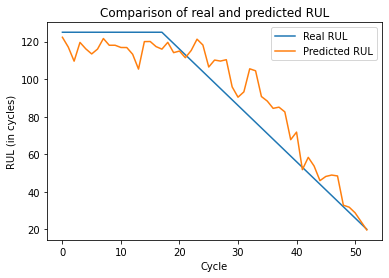

In [15]:
signals_real = []
signals_pred = []
is_larger = [False] + [y_test[i + 1] > y_test[i] for i in range(0, len(y_test) - 1)]

j = 0
for i in range(len(y_test)):
    if is_larger[i]:
        j += 1
    try:
        signals_real[j]
        signals_pred[j]
    except:
        signals_real.append([])
        signals_pred.append([])

    signals_real[j].append(y_test[i])
    signals_pred[j].append(y_test_predict[i])

sig = 22
plt.figure()
plt.subplot(1, 1, 1)
plt.plot(np.arange(len(signals_real[sig])), signals_real[sig])
plt.plot(np.arange(len(signals_pred[sig])), signals_pred[sig])
plt.xlabel("Cycle")
plt.ylabel("RUL (in cycles)")
plt.title("Comparison of real and predicted RUL")
legend = plt.legend(["Real RUL", "Predicted RUL"])
plt.setp(legend.get_texts(), color="black")
plt.show()

The figure suggests that the model shows that the lower predicted RUL values are closer to the groundtruth than higher RUL values.

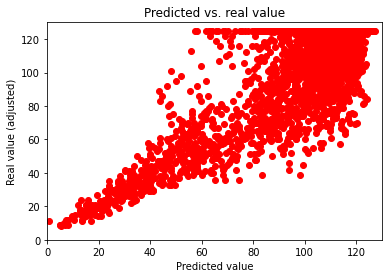

In [16]:
plt.figure()
plt.plot(y_test_predict, y_test, "ro")
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.xlabel("Predicted value")
plt.ylabel("Real value (adjusted)")
plt.title("Predicted vs. real value")
plt.show()